In [27]:
%reload_ext autoreload
%autoreload 2
from dataset import IEEE_CIS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
dm = IEEE_CIS()
energy_data = dm.load_energy_data()
# Change this if you want to see different dataset
# Only work on Solar dataset since Building ones have NaN, and I don't know how to deal with them
name = 'Solar0'

In [29]:
split_idx = len(energy_data[name][:dm.PHASE1_TIME]) - 1
start_time = energy_data[name].index[0]
end_time = energy_data[name].index[-1]
print(split_idx, start_time, end_time)

59948 2019-01-15 13:00:00 2020-11-30 23:45:00


In [30]:
### Load weather data
weather_data = dm.load_ERA5_weather_data()
weather_data = weather_data.drop(['coordinates (lat,lon)', 'model (name)', 'utc_offset (hrs)', 'model elevation (surface)'], axis=1)
weather_data = weather_data.resample("15min").asfreq()
weather_data = weather_data.fillna(method='ffill')

In [35]:
day = 24*60*60
year = (365.2425)*day

data = energy_data[name]

# Saved max and min for denormalize later
y_norm_val = [data['energy'].max(), data['energy'].min()]

IS_NORM = True
# Normalize value
if IS_NORM:
  data = (data-data.min())/(data.max()-data.min())

data = data.join(weather_data)
# Transform timestamp into seconds
time_stamp = data.index.map(pd.Timestamp.timestamp)
# Transform raw seconds into sin and cos value, creating a seasonal value that represent the repeat of day and year
data['day_sin'] = np.sin(time_stamp * (2 * np.pi/day))
data['day_cos'] = np.cos(time_stamp * (2 * np.pi/day))
data['year_sin'] = np.sin(time_stamp * (2 * np.pi/year))
data['year_cos'] = np.cos(time_stamp * (2 * np.pi/year))

# Stack all of the day and year
X_train = np.array(data[:split_idx].drop(['energy'], axis=1))
X_test = np.array(data[split_idx:].drop(['energy'], axis=1))


# Stack the day and year with weather data
y_train = np.array(data['energy'][:split_idx])
y_true = np.array(data['energy'][split_idx:])

# Remove trash data (bunchs of 0s) does make the model better
#X_train = X_train[2460:]
#y_train = y_train[2460:]

In [36]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_true.shape)

(59948, 12) (5856, 12)
(59948,) (5856,)


In [37]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tinygrid.utils import mase, denormalize

model = [linear_model.Lasso(alpha=0.1),
         linear_model.BayesianRidge(),
         linear_model.Ridge(),
         linear_model.LinearRegression(),
        ]

def fit_and_pred(model, X_train, X_test, y_train, y_true, is_norm, y_norm_val):
  print("Data", name)
  print(f"Model {model}\n")

  # Fit
  model.fit(X_train, y_train)
  r_sq = model.score(X_train, y_train)
  print(f"coefficient of determination: {r_sq}")
  print(f"intercept: {model.intercept_}")
  print(f"slope: {model.coef_}\n")

  # Generate prediction
  y_pred = model.predict(X_test)
  # Denormalize value back to original
  if is_norm:
    y_true  = denormalize(y_true, y_norm_val[0], y_norm_val[1])
    y_pred  = denormalize(y_pred, y_norm_val[0], y_norm_val[1])
    y_train = denormalize(y_train, y_norm_val[0], y_norm_val[1])
  print(f"predicted response:\n{y_pred}")
  print("mean square error:", mean_squared_error(y_true, y_pred))
  print("mean abs error:", mean_absolute_error(y_true, y_pred))
  print("mean absolute scale error", mase(y_pred, y_true, y_train))
  print()

  return y_pred, y_true

Data Solar5
Model Lasso(alpha=0.1)

coefficient of determination: 0.41279942903331746
intercept: 0.08556711197642956
slope: [-0.00000000e+00 -0.00000000e+00  0.00000000e+00  2.31530430e-08
  0.00000000e+00  5.56047415e-04 -2.64454538e-04  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]

predicted response:
[13.14933869 13.14933869 13.14933869 ...  4.86293653  4.86293653
  4.86293653]
mean square error: 60.92475242796905
mean abs error: 4.660423071201029
mean absolute scale error 1.6252553322222292

Data Solar5
Model BayesianRidge()

coefficient of determination: 0.466514061534834
intercept: -0.08682971607776346
slope: [-1.04218219e-02  8.52224885e-03  2.16252685e-03  2.46721069e-06
 -8.39185245e-02  5.68758733e-04 -1.10606145e-04  6.62373133e-03
 -1.33121797e-02  3.50721833e-02 -3.74969989e-02  3.98739908e-02]

predicted response:
[16.31181841 16.27387085 16.23001501 ...  7.60461424  7.58488892
  7.5588427 ]
mean square error: 46.62333009442768
mean abs

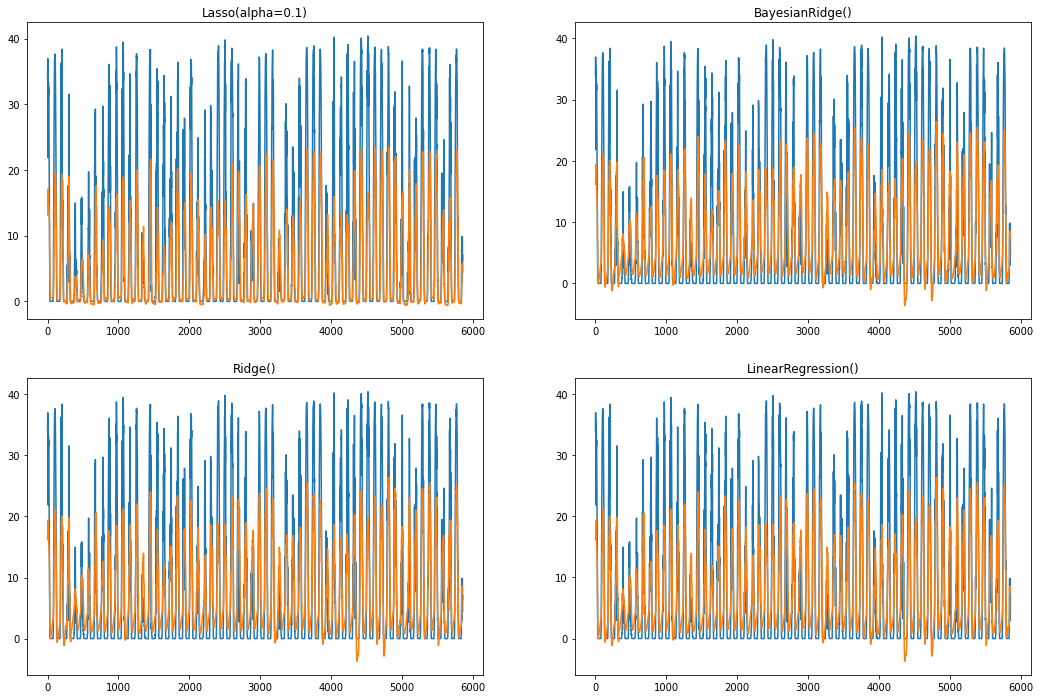

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
ll = range(y_true.shape[0])
for idx, m in enumerate(model):
  y_p, y_t = fit_and_pred(m, X_train, X_test, y_train, y_true, IS_NORM, y_norm_val)
  axs[idx//2, idx%2].plot(ll, y_t)
  axs[idx//2, idx%2].plot(ll, y_p)
  axs[idx//2, idx%2].title.set_text(m)
